In [25]:
import os
import sys
import argparse
import logging
import shutil
from sklearn.decomposition import PCA
import pickle
import pandas as pd

logging.captureWarnings(True)

import matplotlib

if sys.platform == 'linux':
    print('Use non-interactive Agg backend for matplotlib on linux')
    matplotlib.use('Agg')

import matplotlib.pyplot as plt
import numpy as np
import torch

sys.path.append('..')
from mdlearn import fitting, visualize, metrics, preprocessing, validation, dataloader


In [26]:
class OPT():
    def __init__(self):
        pass
    
opt = OPT()
opt.input = '../data/result-ML-CH-cp.txt'
opt.target = 'cp'
opt.fp = '../run/CH-cp/fp/fp_morgan1,../run/CH-cp/fp/fp_simple'
opt.featrm = ''
opt.part = '../run/CH-cp/out/part-1.txt'
opt.output = '../run/CH-cp/out'
opt.layer = '32,16,8'

In [27]:
def load_data(opt):
    if opt.layer != "":
        layers = list(map(int, opt.layer.split(',')))
    else:
        layers = []

    if not os.path.exists(opt.output):
        os.mkdir(opt.output)

    if opt.featrm == 'auto':
        logger.info('Automatically remove features')
        featrm = [14, 15, 17, 18, 19, 20, 21, 22]
    elif opt.featrm == '':
        featrm = []
    else:
        featrm = list(map(int, opt.featrm.split(',')))

    datax, datay, data_names = dataloader.load(filename=opt.input, target=opt.target, fps=opt.fp.split(','), featrm=featrm)

    selector = preprocessing.Selector(datax, datay, data_names)
    if opt.part:
        selector.load(opt.part)
    else:
        selector.partition(0.8, 0.1)
        selector.save(opt.output + '/part.txt')
        
    trainx, trainy, trainname = selector.training_set()
    validx, validy, validname = selector.validation_set()
    '''
    scaler = preprocessing.Scaler()
    scaler.fit(trainx)
    scaler.save(opt.output + '/scale.txt')
    normed_trainx = scaler.transform(trainx)
    normed_validx = scaler.transform(validx)
    '''
    #model = fitting.TorchMLPRegressor(None, None, [],
    #                                  is_gpu= False,
    #                                  )
    #model.load(opt.output + '/model.pt')
    
    return trainx, trainy, validx, validy, trainname, validname, model

In [36]:
trainx, trainy, validx, validy, trainname, validname, model = load_data(opt)

In [37]:
[unique_trainx, idx] = np.unique(trainx[:,:-2],axis=0,return_index=True)
appear_count = (unique_trainx != 0).sum(axis=0)
appear_sort = np.argsort(appear_count)

In [45]:
appear_count

array([  94,  389,  336,  136,   83,   69,   92,  546,  190,  114,  667,
        105,   81,  125,  233,  196,  315,  475,   93,   86,  190,  393,
        113,  267,  182,   86,   98,  103,  509,  126,  465,  941,  552,
       1504,  336,  454, 2095,  352,  102,  236,  872,   92,  644,  208,
        118,  137,  144,  123,  814,  828,  825,  508, 1207,  120,  263,
        155,  179,  123, 2309, 2309, 2309, 2174,  275,    7,  119,   66,
         71,  283,  520,   66,   31,  595])

In [39]:
appear_sort

array([63, 70, 69, 65,  5, 66, 12,  4, 19, 25, 41,  6, 18,  0, 26, 38, 27,
       11, 22,  9, 44, 64, 53, 47, 57, 13, 29,  3, 45, 46, 55, 56, 24,  8,
       20, 15, 43, 14, 39, 54, 23, 62, 67, 16, 34,  2, 37,  1, 21, 35, 30,
       17, 51, 28, 68,  7, 32, 71, 42, 10, 48, 50, 49, 40, 31, 52, 33, 36,
       61, 59, 58, 60], dtype=int64)

In [34]:
from IPython.display import SVG
import matplotlib.image as mpimg

svg_files = list(os.listdir('../run/CH-cp/fp/fp-svg_morgan1'))
svg_files.remove('png')
svg_files.remove('svg2png.py')
with open('../run/CH-cp/fp/fp_morgan1.idx') as file:
    all_the_text = file.read()
fp_idx = {int(fp):idx for idx,fp in enumerate(all_the_text.split('\n')[:-1])}

class fp_svg():
    def __init__(self, svg_file, fp_idx):
        self.freq = int(svg_file.split('-')[0])
        self.fp = int(svg_file.split('-')[1])
        self.fp_name = svg_file.split('-')[2].split('.')[0]
        self.idx = fp_idx[self.fp] 
        with open('../run/CH-cp/fp/fp-svg_morgan1/'+svg_file) as file:
            self.svg = file.read()
        self.png = mpimg.imread('../run/CH-cp/fp/fp-svg_morgan1/png/'+svg_file.split('.')[0]+'.png')
fp_svgs = sorted([fp_svg(file_name, fp_idx) for file_name in svg_files], key=lambda x: x.idx ) 

In [5]:
with open(opt.output + '/sobol_idx.pkl', 'rb') as file:
    sobol_idx = pickle.load(file)
with open(opt.output + '/sobol_S1.pkl', 'rb') as file:
    sobol_S1 = pickle.load(file)

In [35]:
trainx, trainy, validx, validy, trainnames, validnames, model = load_data(opt)

In [7]:
scaler = preprocessing.Scaler()
scaler.load(opt.output + '/scale.txt')
# normed_trainx = scaler.transform(trainx)
normed_validx = scaler.transform(validx)
predy = model.predict_batch(normed_validx)

In [8]:
idx_bigerr = abs((predy-validy)/validy)>0.03

In [9]:
idx_be = [] 
for i,item in enumerate(idx_bigerr):
    if item[0]==True:
        idx_be.append(i)

In [10]:
[unique_bad_validx, idx] = np.unique(validx[idx_be,:-2],axis=0, return_index=True)

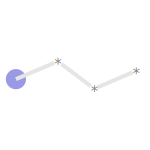

In [11]:
SVG(fp_svgs[0].svg)

In [12]:
[unique_trainx, idx] = np.unique(trainx[:,:-2],axis=0,return_index=True)
unique_name = np.array(trainnames)[idx]

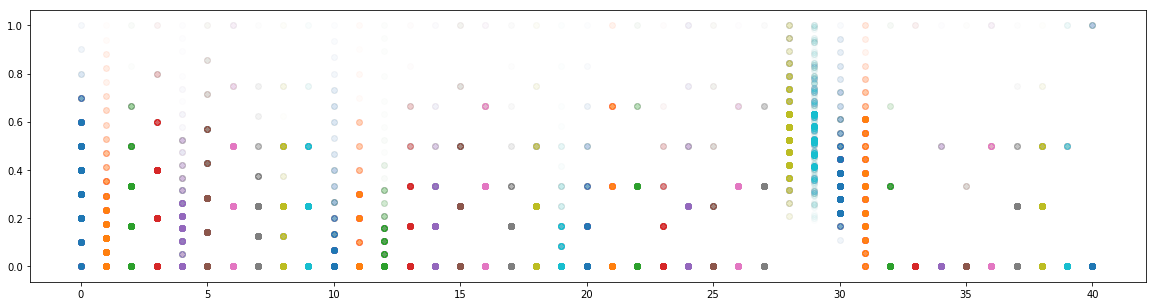

In [20]:
trainx_max = trainx.max(axis=0)

plt.figure(figsize=(20,5))
for k in range(41):
    plt.scatter([k for i in range(unique_trainx.shape[0])], unique_trainx[:,k]/trainx_max[k],alpha=0.01)

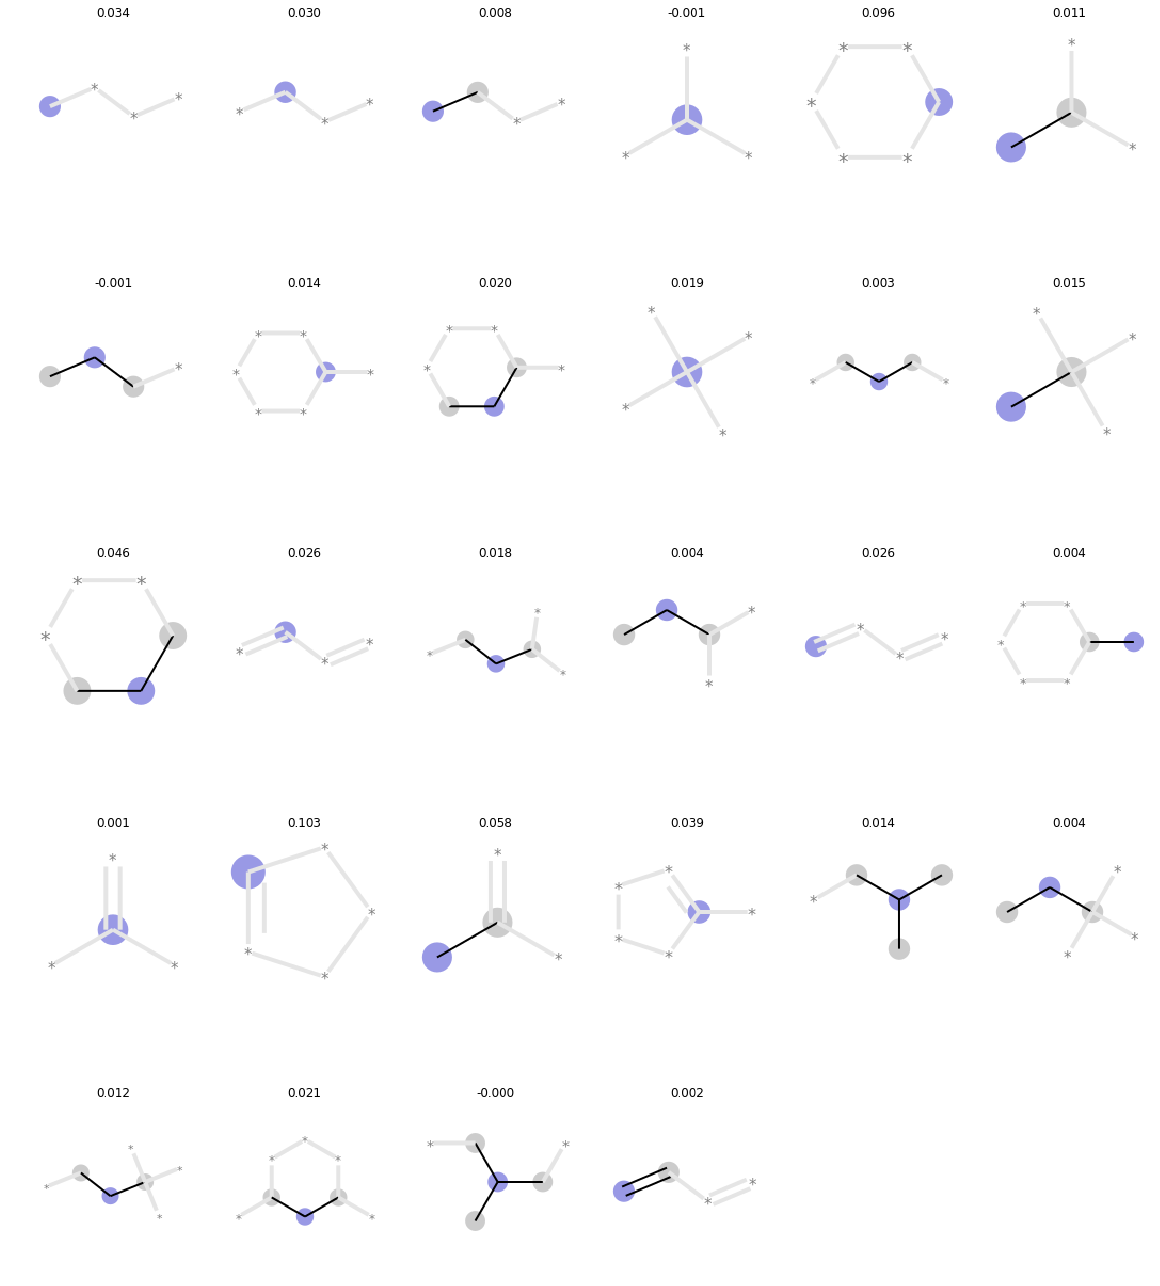

In [14]:
fig = plt.figure(figsize=(20,24))
for i in range(28):
    ax = fig.add_subplot(5,6,i+1)
    ax.axis('off')
    ax.imshow(fp_svgs[i].png)
    ax.title.set_text( '{:.3f}'.format(sobol_S1[i]) )

In [48]:
simple_feature = ['heavy atoms','molecular weight x10','Wiener length', 'rotatable bond', 'bridged ring', 'spiro ring', 'RR ring', 'R-R ring', '3R+4R', '5R', '6R', '7R+8R', '>8R','Aromatic R'] 

In [62]:
# Cp RFE selection
a = np.array([70, 27, 22, 38, 36, 35, 34, 33, 32, 42, 43, 49, 44, 45, 52, 56, 54, 12, 64, 62, 25, 9, 28, 66, 55, 59, 63, 37, 24, 41, 11, 21, 15,  6, 13, 19,  8, 69, 61, 53,  5, 46, 26, 60, 57, 30, 39, 17, 7,  4, 31,  2, 20, 40, 23, 51, 58, 47, 10,  1, 14, 1,  3, 68, 67, 65, 48, 18, 29, 50, 16,1, 1, 1])
a < 25   

array([False, False,  True, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False, False,  True, False, False, False, False, False,
       False,  True, False,  True,  True,  True,  True,  True,  True,
        True, False, False, False,  True, False, False, False, False,
       False, False,  True,  True,  True, False,  True,  True, False,
        True, False, False, False,  True,  True,  True,  True,  True,
       False, False, False, False,  True, False, False,  True,  True,
        True,  True])

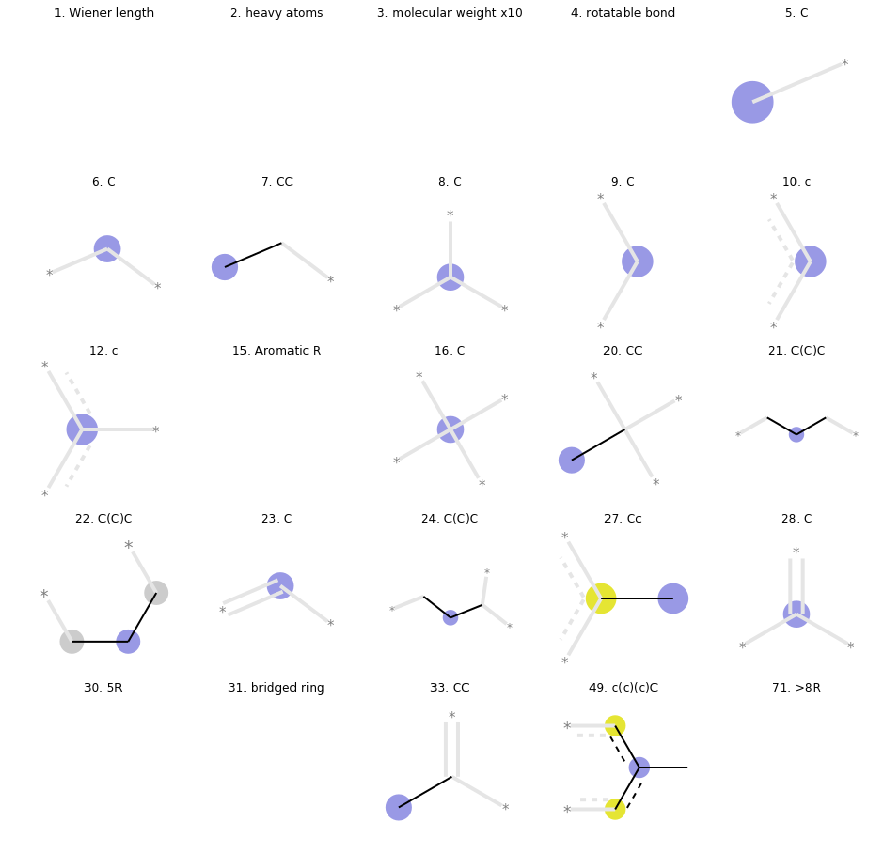

In [73]:
# draw selected feature set
fig = plt.figure(figsize=(15,15))
count = 1
for i in range(1, len(appear_sort)+1):
    idx = appear_sort[-i]
    if a[idx] < 24:
        ax = fig.add_subplot(5,5,count)
        ax.axis('off')
        if idx < 58:
            ax.imshow(fp_svgs[idx].png)
            ax.title.set_text( '{:d}. {:s}'.format(i, fp_svgs[idx].fp_name) )
        else:
            ax.title.set_text( '{:d}. {:s}'.format(i, simple_feature[idx-58]) )
        count += 1

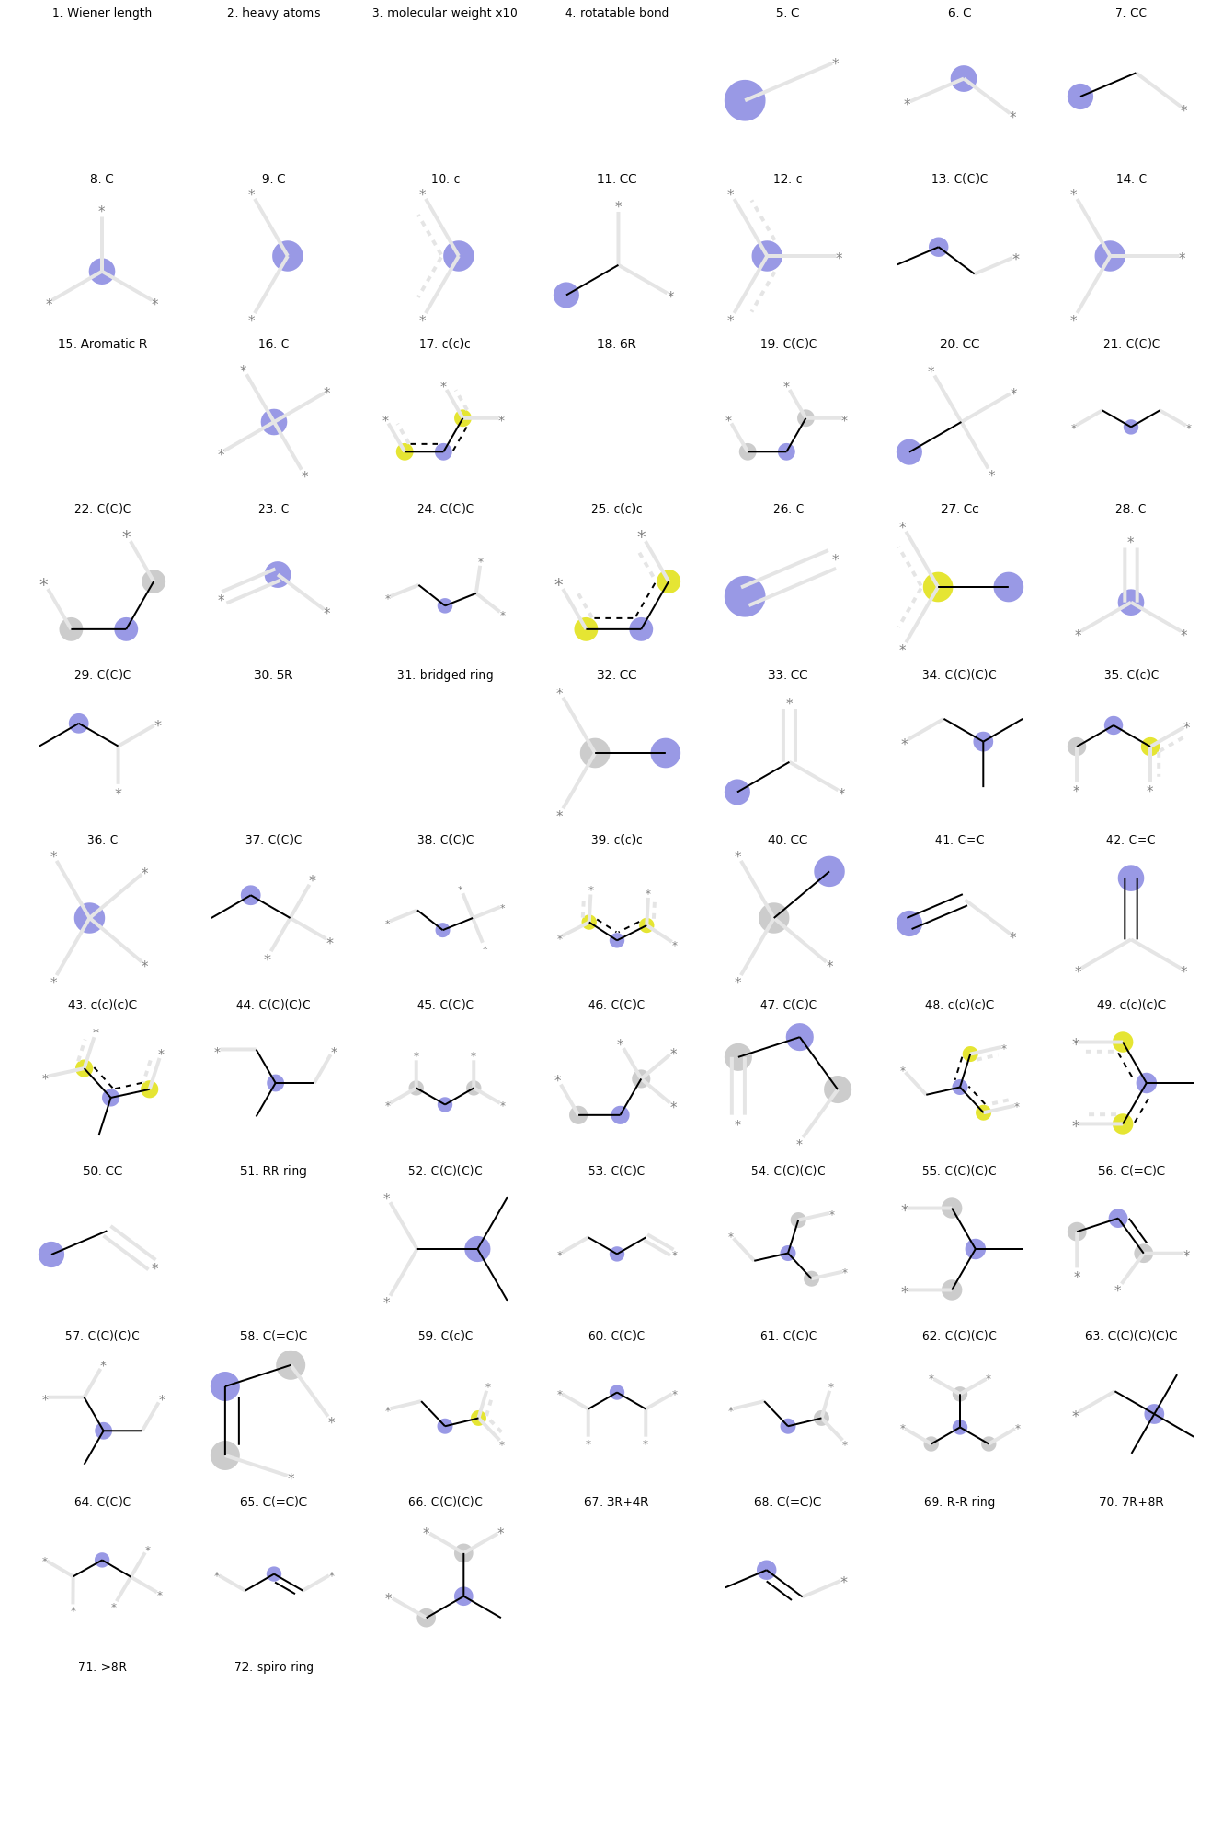

In [59]:
# draw full feature set
fig = plt.figure(figsize=(21,36))
for i in range(1, len(appear_sort)+1):
    ax = fig.add_subplot(12,7,i)
    ax.axis('off')
    idx = appear_sort[-i]
    if idx < 58:
        ax.imshow(fp_svgs[idx].png)
        ax.title.set_text( '{:d}. {:s}'.format(i, fp_svgs[idx].fp_name) )
    else:
        ax.title.set_text( '{:d}. {:s}'.format(i, simple_feature[idx-58]) )

In [47]:
71-58

13

In [58]:
#draw one card for each feature, sorted by sensitivity
def feature_card(n, sobol_idx, sobol_S1,fp_svgs,unique_trainx, unique_bad_validx, fontsize=15):
    idx = sobol_idx[-n]
    f = plt.figure(figsize=(10,5))
    gs = matplotlib.gridspec.GridSpec(2, 3)
    a0 = plt.subplot(gs[:, 0])
    a1 = plt.subplot(gs[0,1:])
    a2 = plt.subplot(gs[1,1:],sharex=a1)
    if idx<28: # if fp,
        a0.imshow(fp_svgs[idx].png)
        a0.axis('off')
        a0.title.set_text( '{:s}\nsensitivity:{:.3f},rank:{:d}-th\ntotal {:d} appearence in {:d} moleculars'.format(fp_svgs[idx].fp_name,sobol_S1[idx],n,int(sum(unique_trainx[:,idx])),int(sum(unique_trainx[:,idx]!=0))))
        a0.title.set_fontsize(fontsize)
        # convert data to 
    else:
        a0.text(0, 0.7, simple_feature[idx-28],fontsize= fontsize)
        a0.text(0, 0.5, 'sensitivity:{:.3f}\nrank:{:d}-th\ntotal {:d} appearence in {:d} moleculars'.format(sobol_S1[idx],n,int(sum(unique_trainx[:,idx])),int(sum(unique_trainx[:,idx]!=0)) ),fontsize= fontsize)
        a0.axis('off')
    bins_train = max(int(max(unique_trainx[:,idx])-min(unique_trainx[:,idx])+0.5),1)
    bins_valid = max(int(max(unique_bad_validx[:,idx])-min(unique_bad_validx[:,idx])+0.5),1)
    a1.hist(unique_trainx[:,idx],align='left',bins=bins_train,rwidth=0.9)
    a1.title.set_text('train feature distribution')
    a1.title.set_fontsize(fontsize)
    a2.hist(unique_bad_validx[:,idx],align='left',bins=bins_valid,color='darkorange',rwidth=0.95)
    a2.title.set_text('large validation error feature distribution')
    a2.title.set_fontsize(fontsize)
    f.tight_layout()
    if n<10:
        f.savefig('png/feature0'+str(n)+'.png')
    else:
        f.savefig('png/feature'+str(n)+'.png')

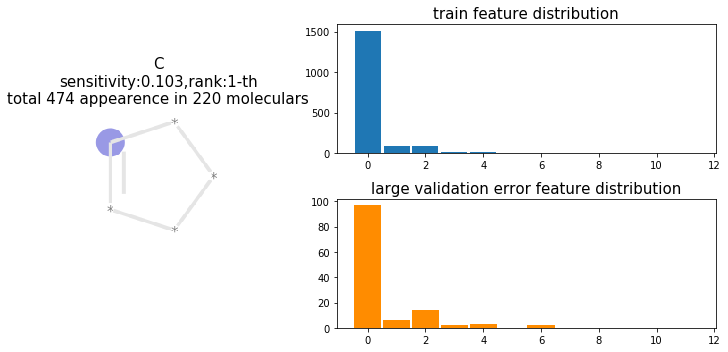

In [59]:
feature_card(1,sobol_idx, sobol_S1,fp_svgs,unique_trainx, unique_bad_validx)

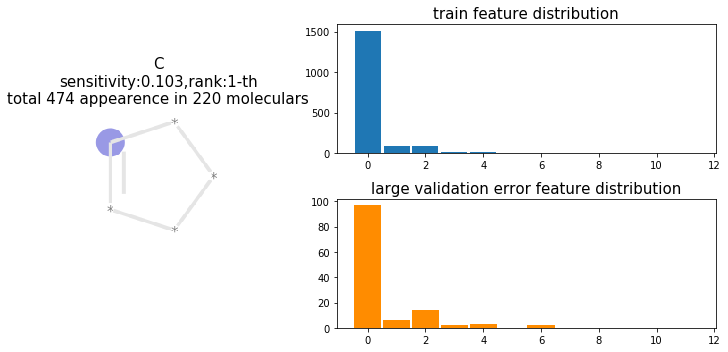

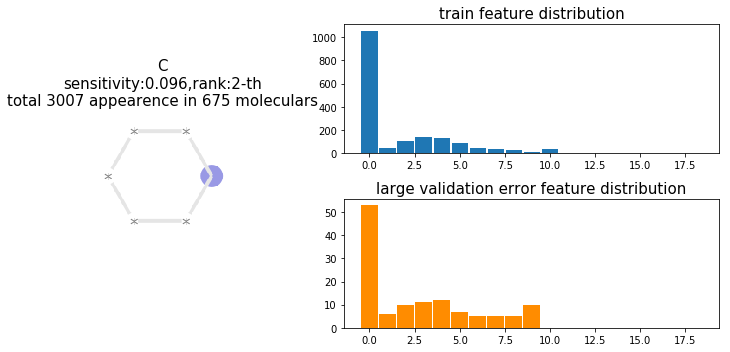

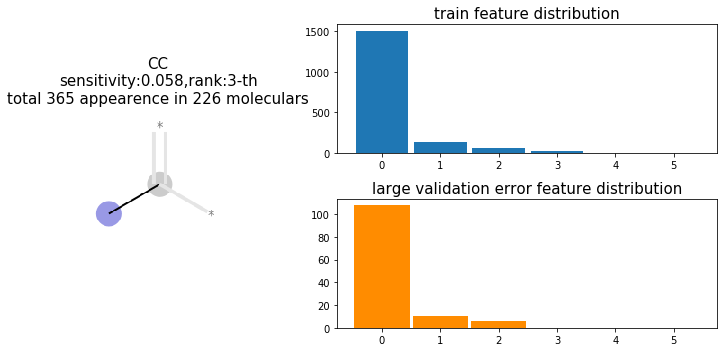

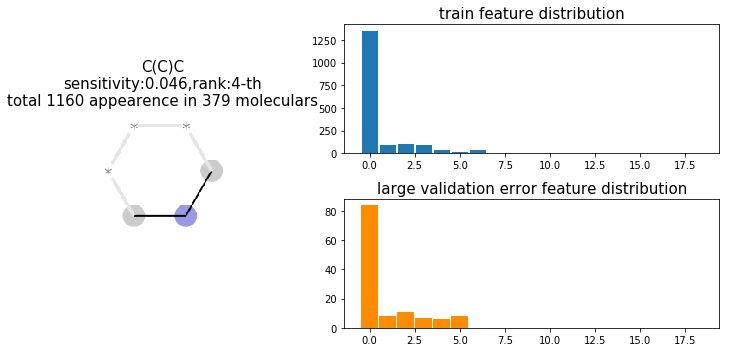

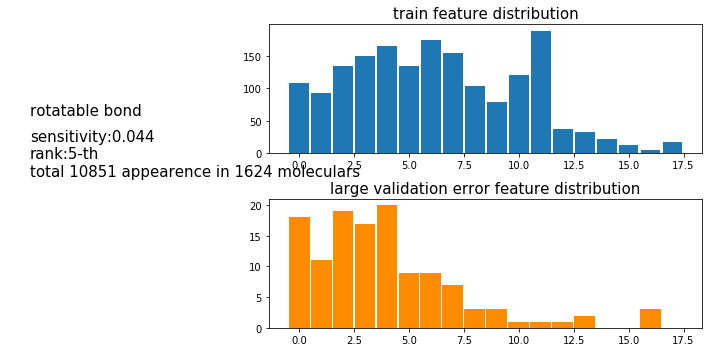

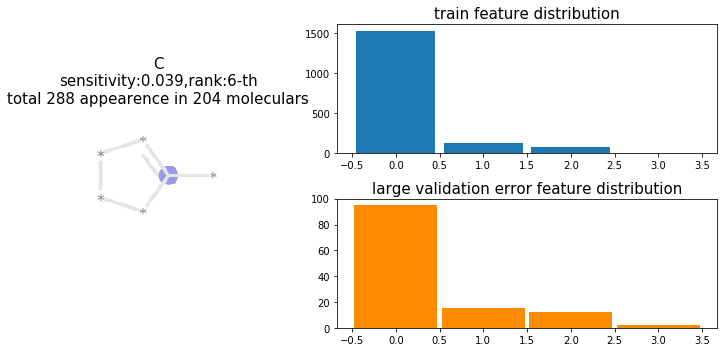

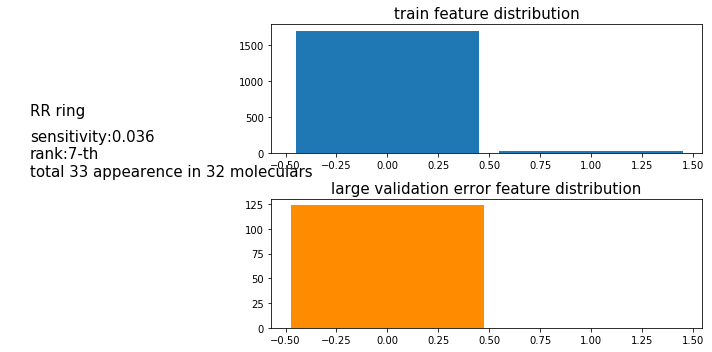

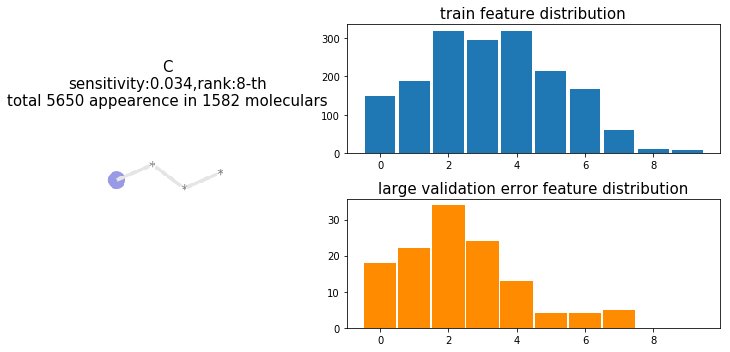

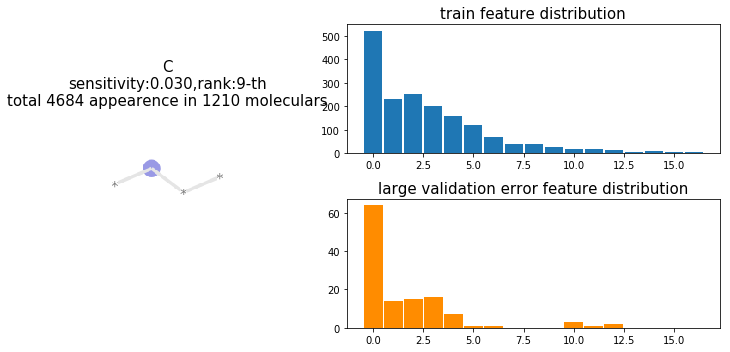

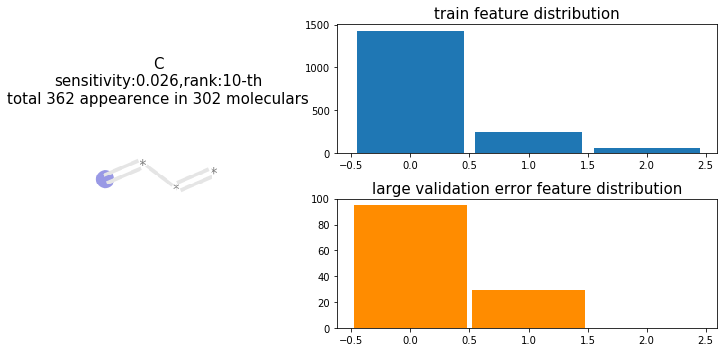

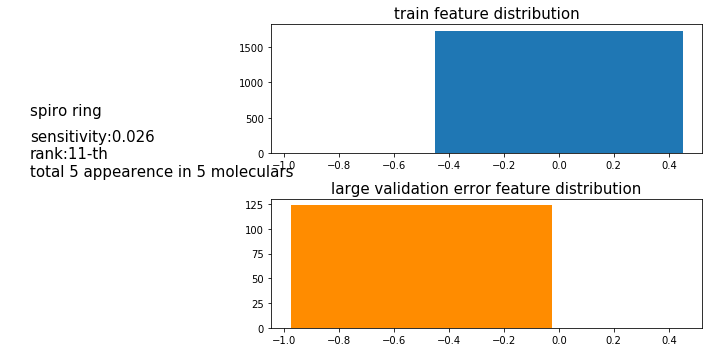

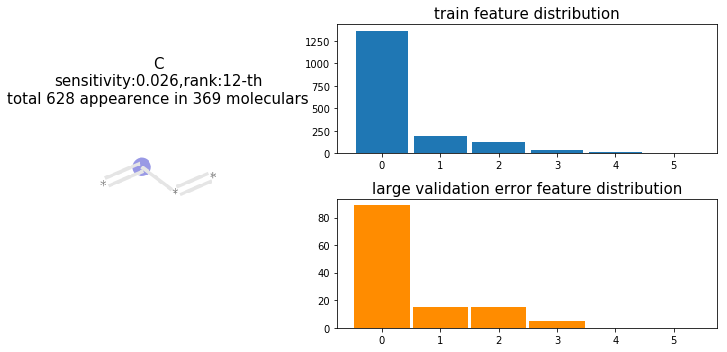

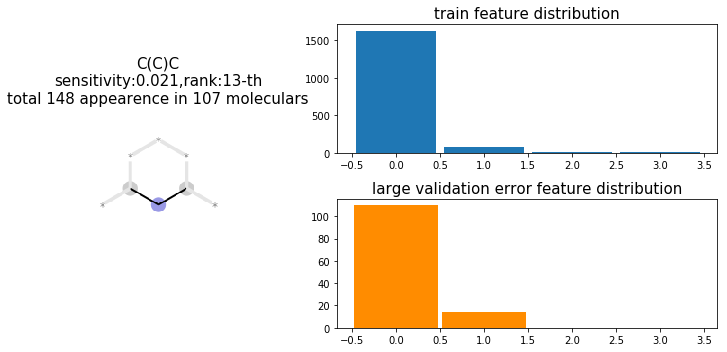

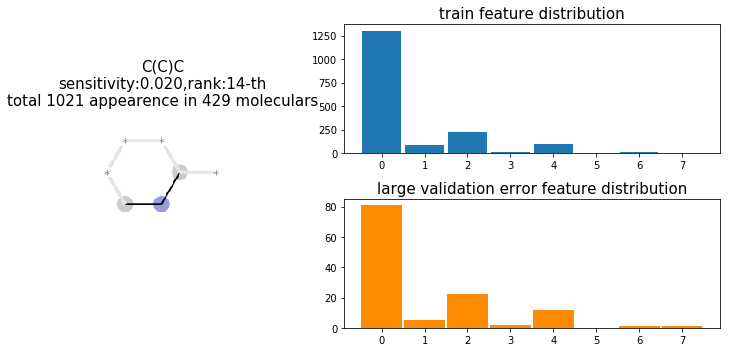

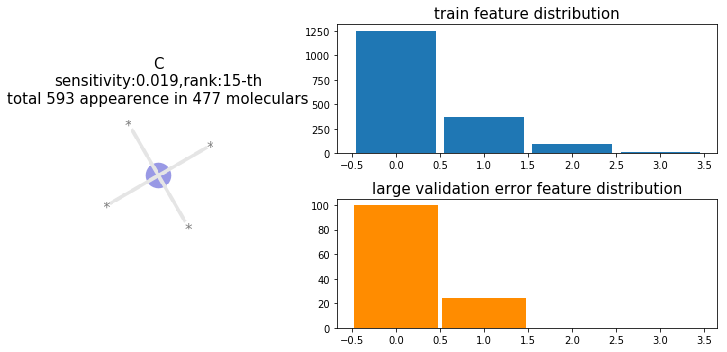

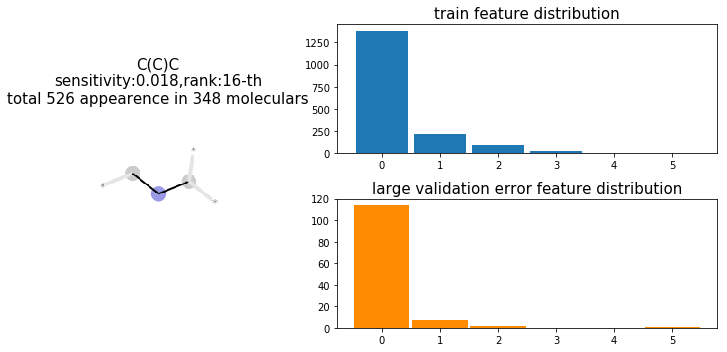

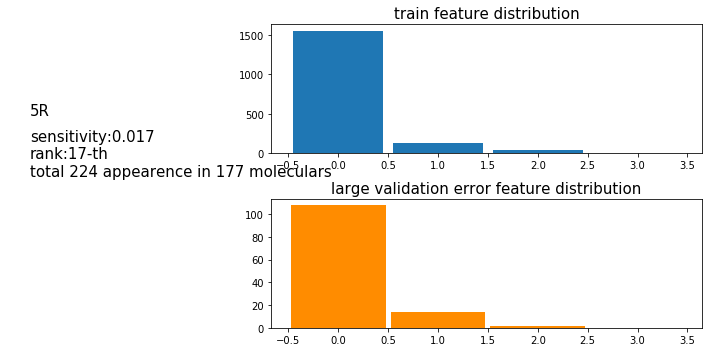

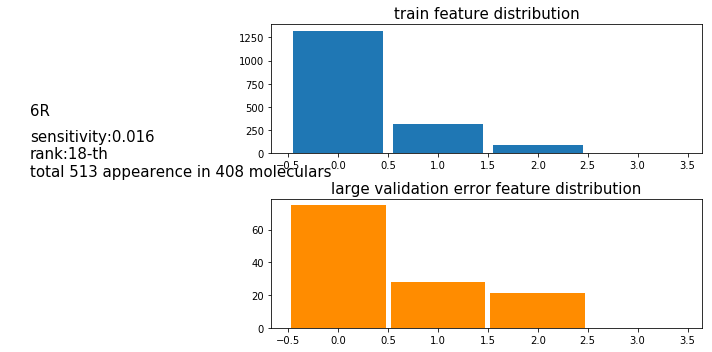

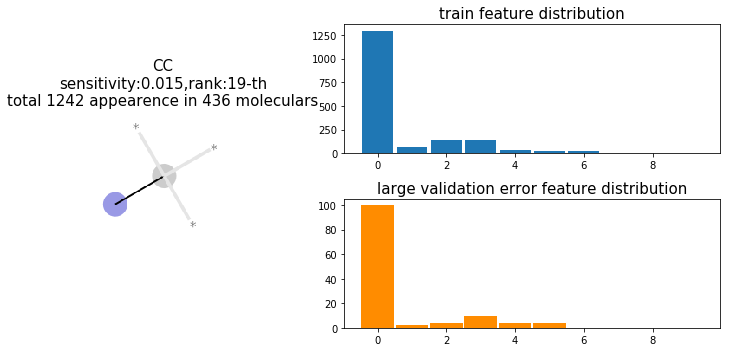

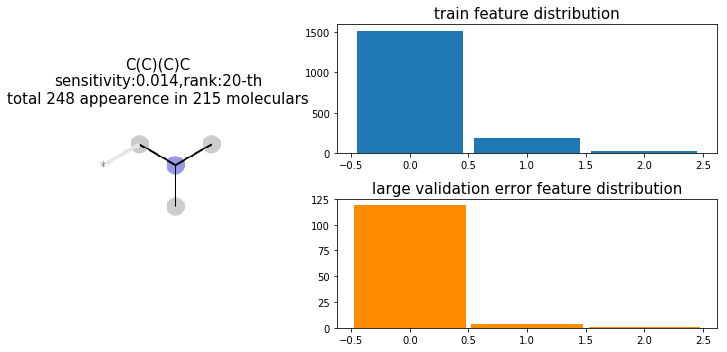

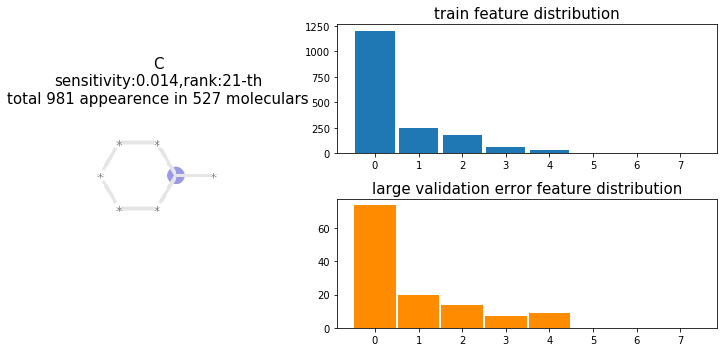

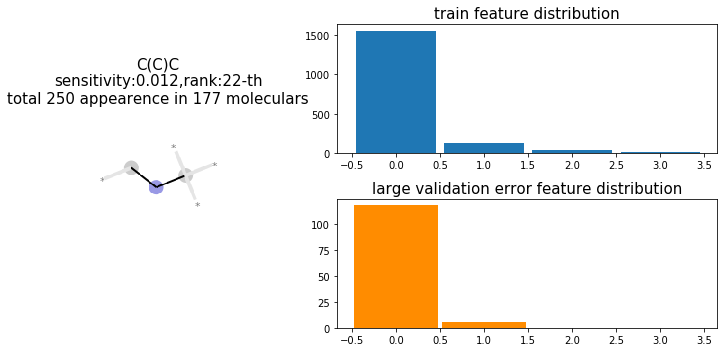

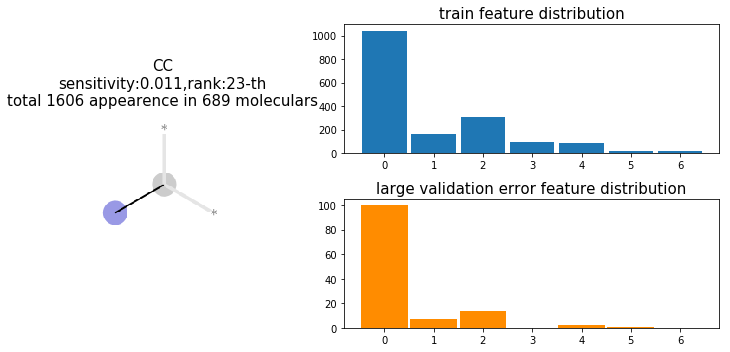

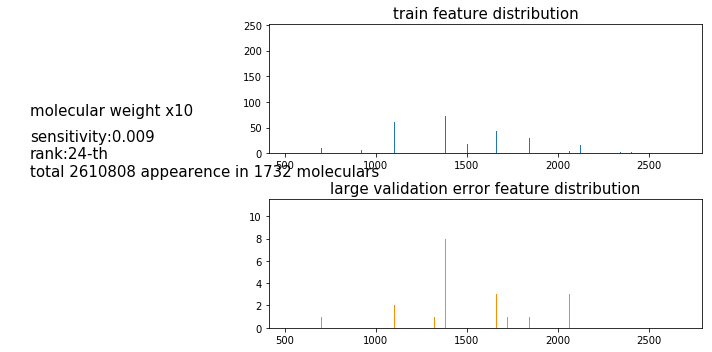

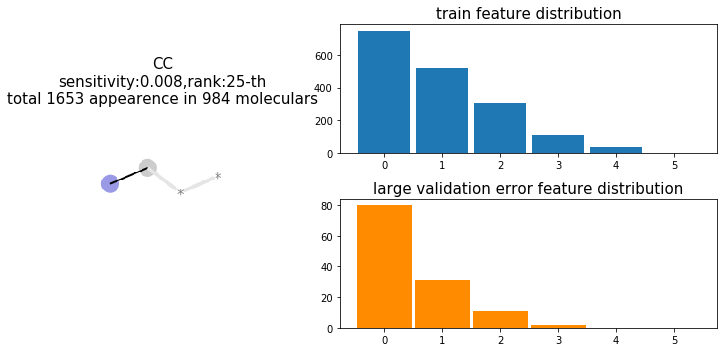

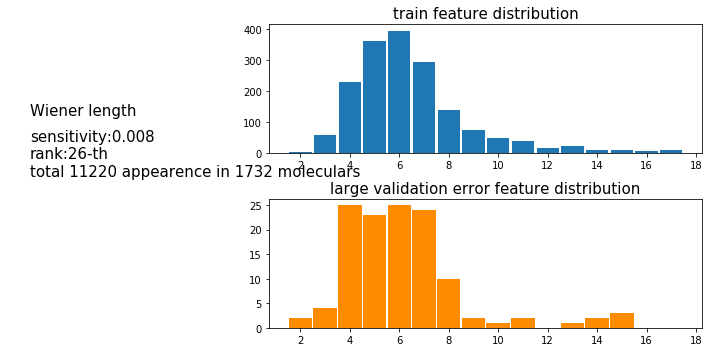

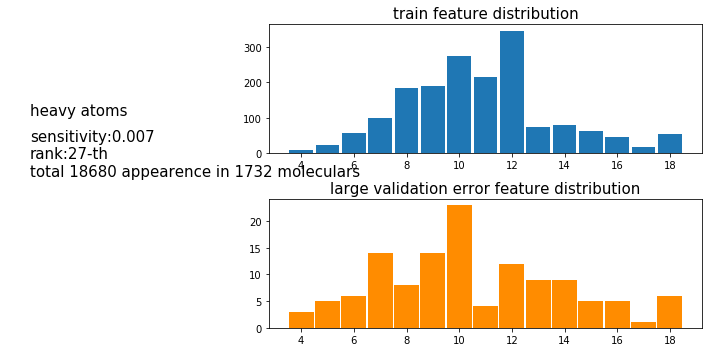

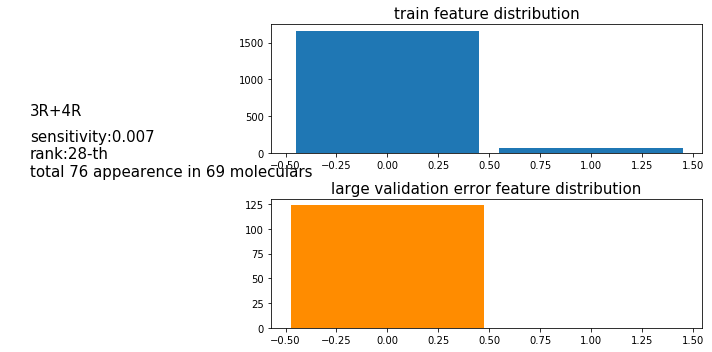

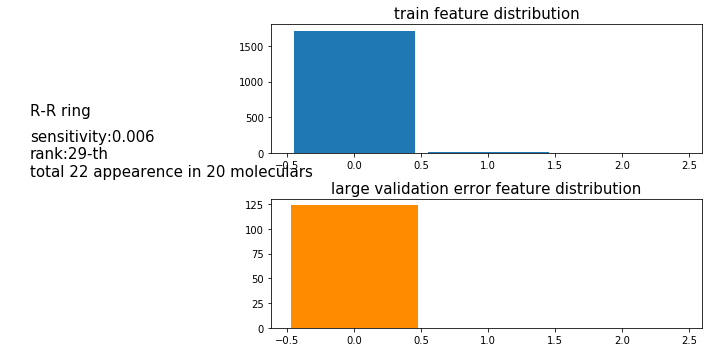

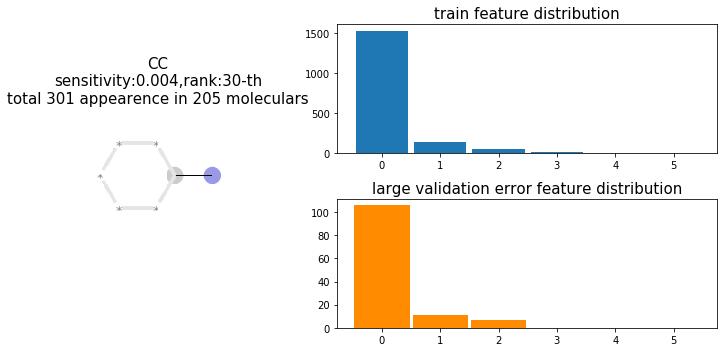

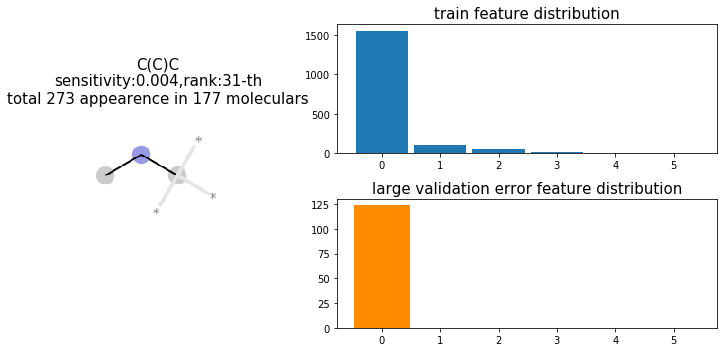

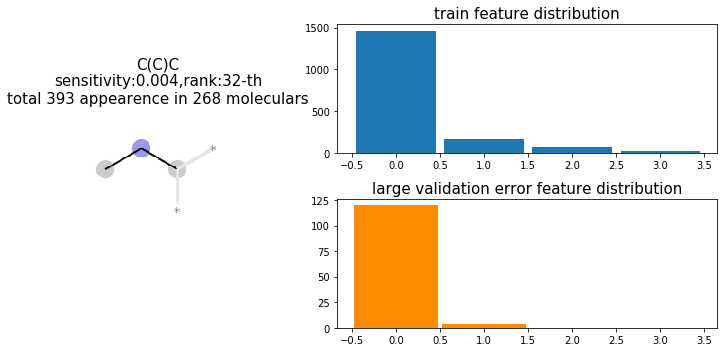

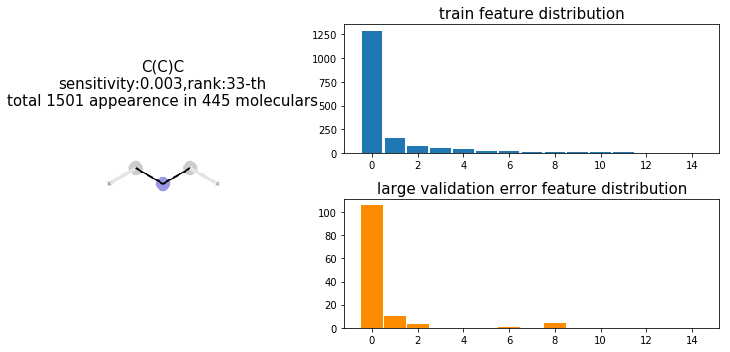

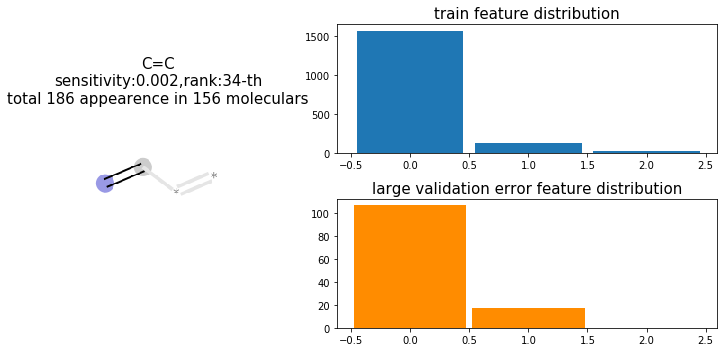

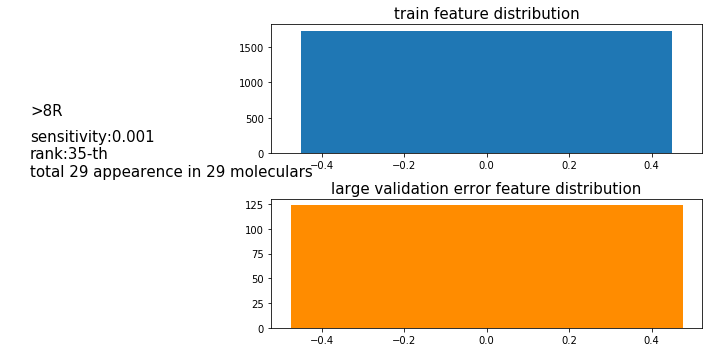

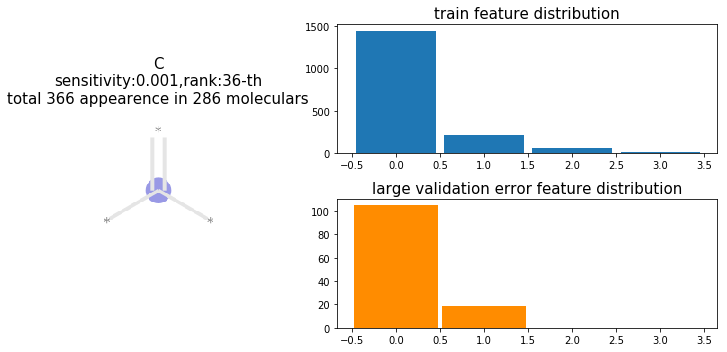

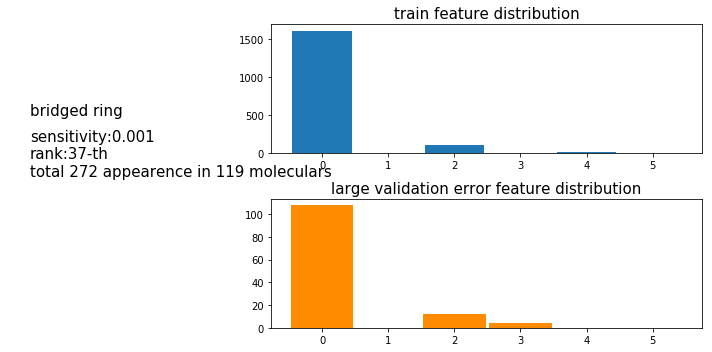

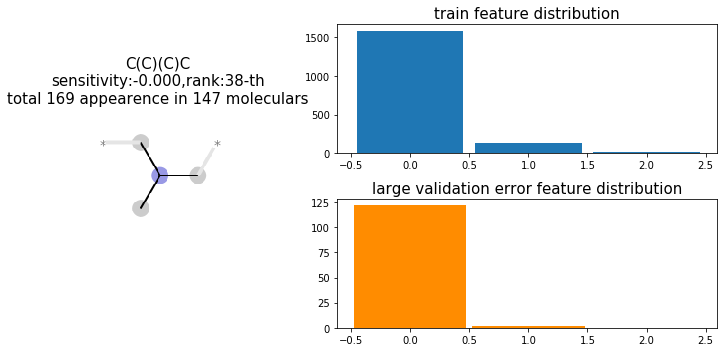

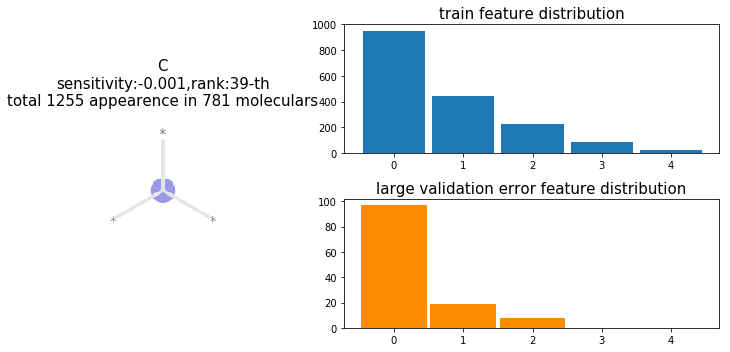

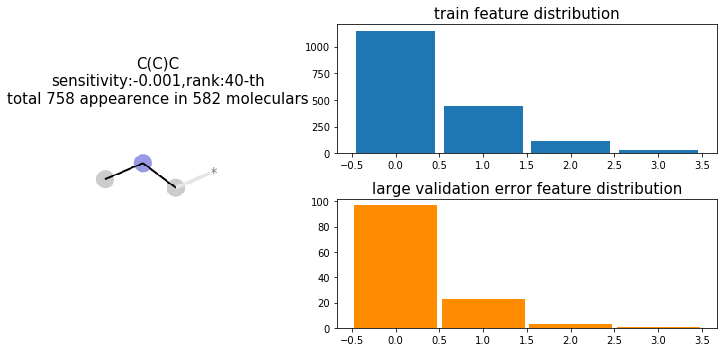

In [60]:
for i in range(1,41):
    feature_card(i,sobol_idx, sobol_S1,fp_svgs,unique_trainx, unique_bad_validx)

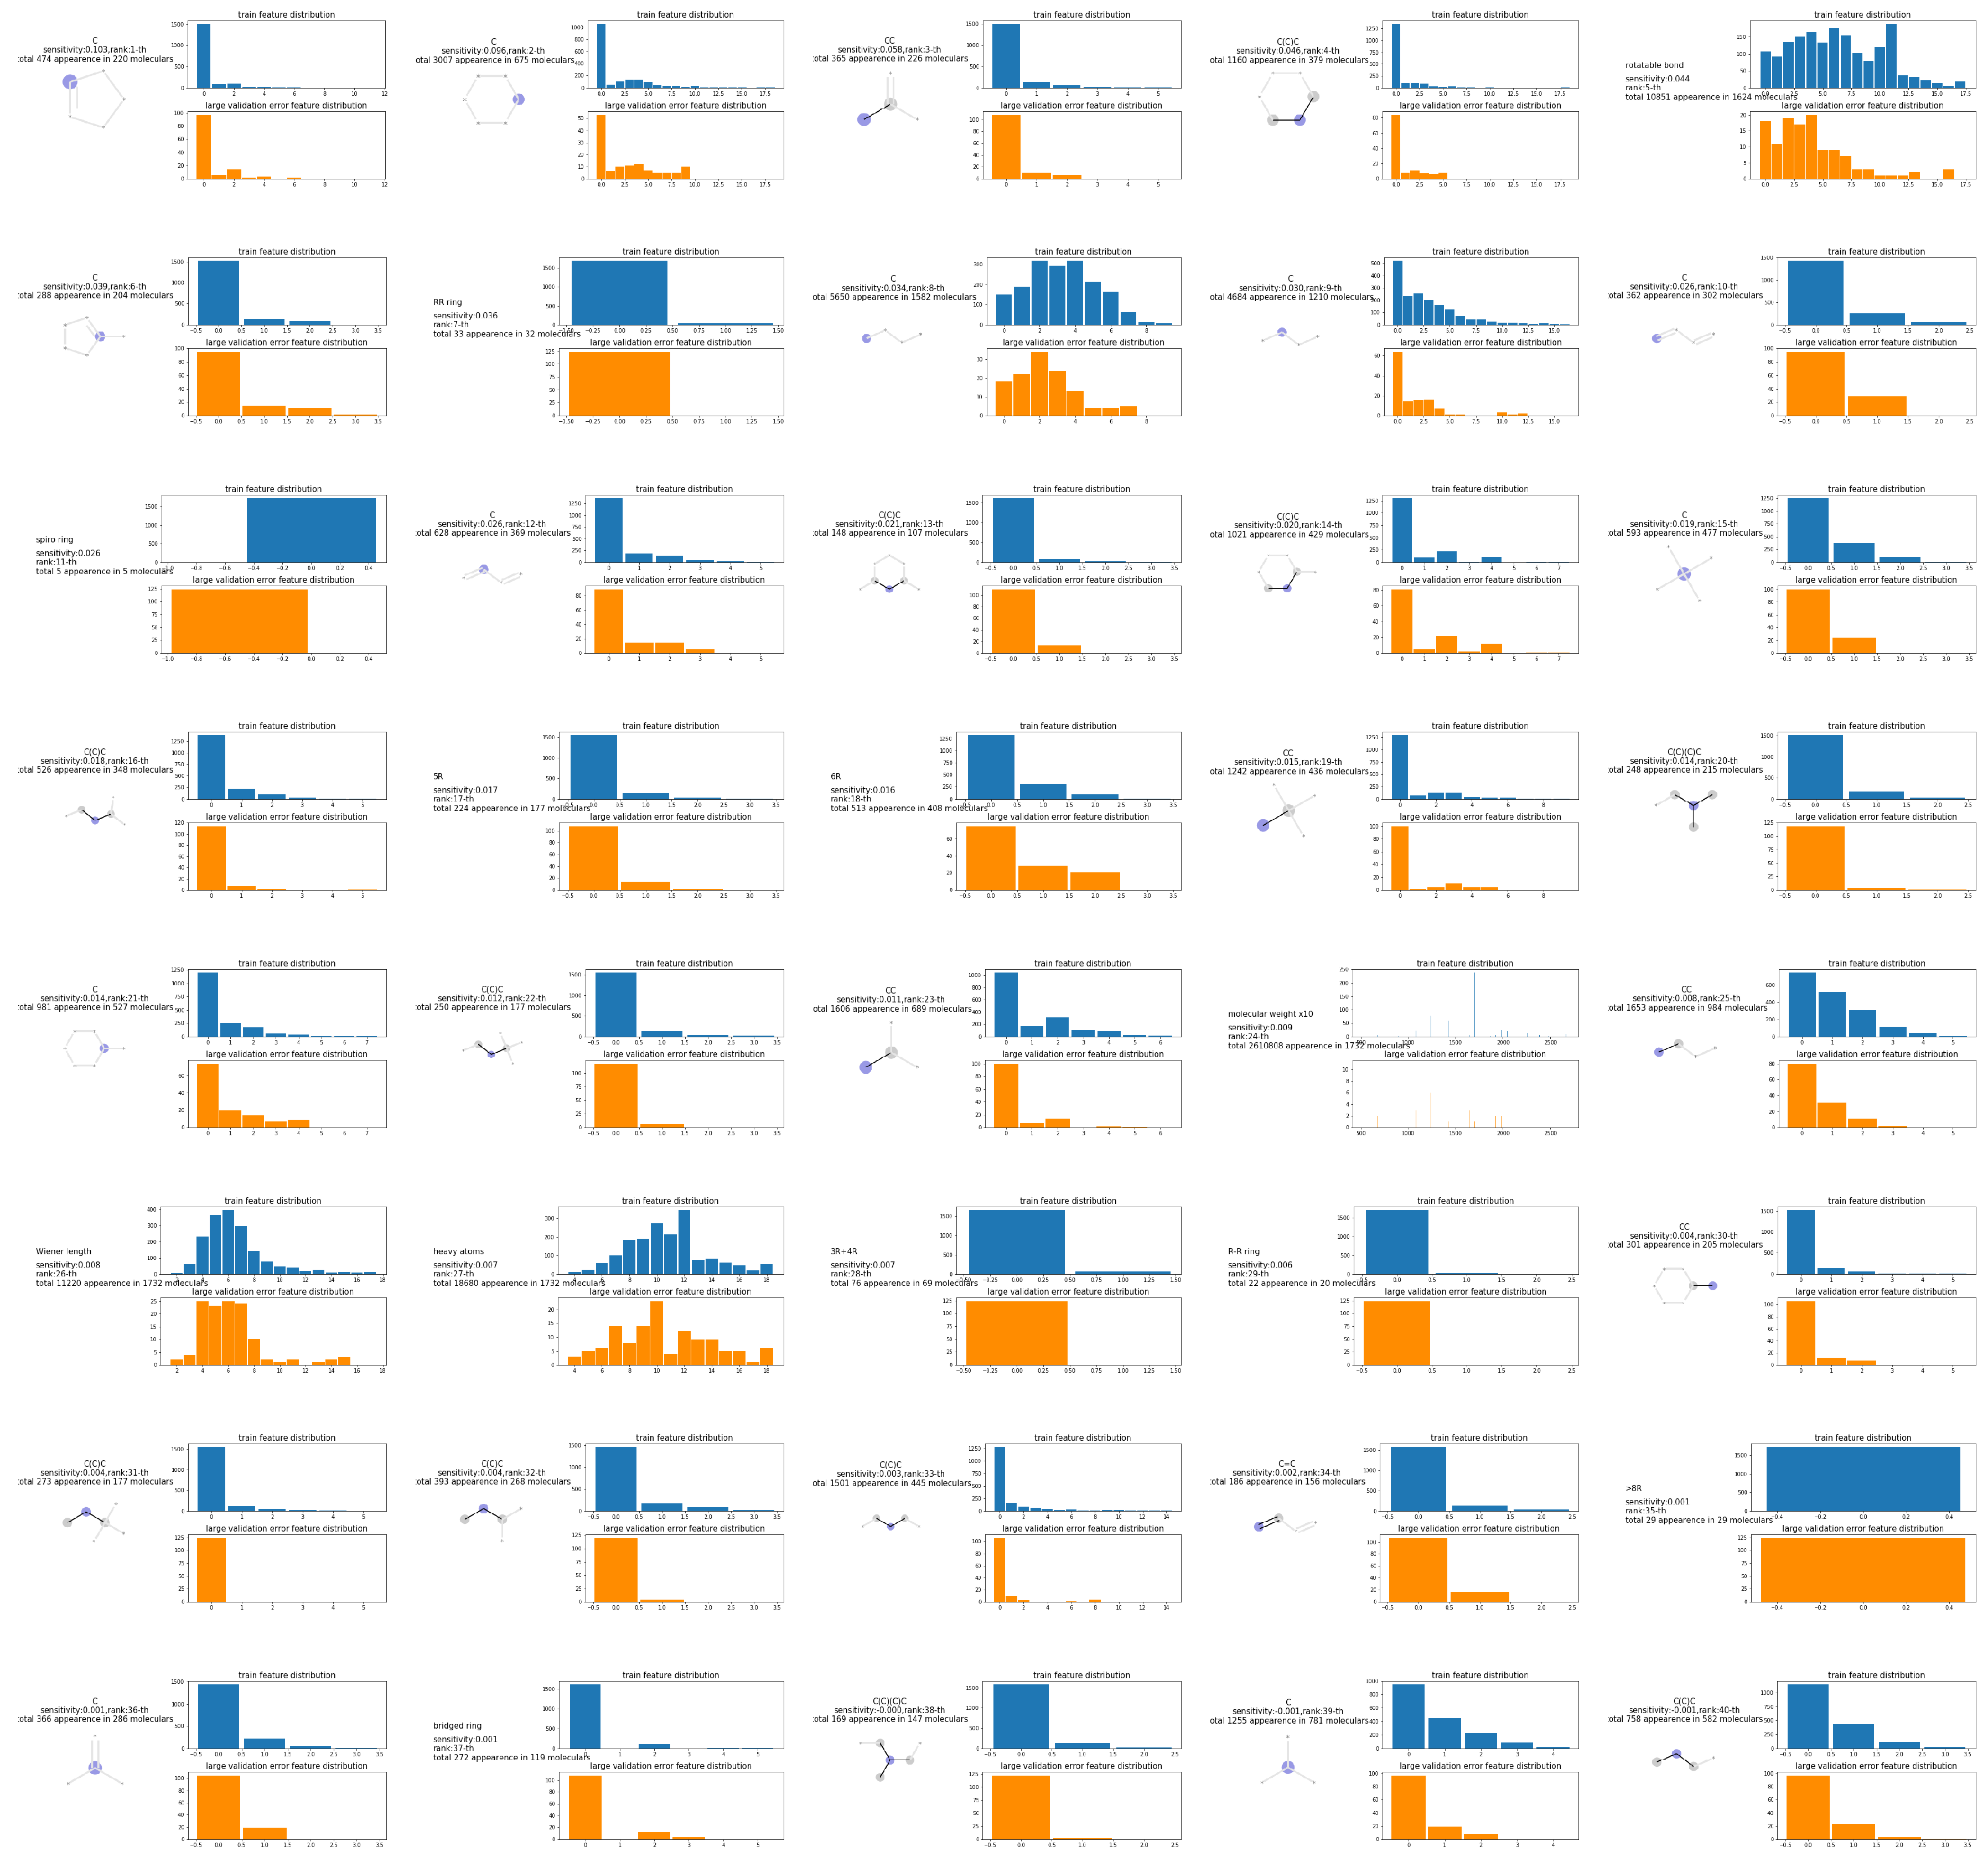

In [61]:
feature_files = sorted(list(os.listdir('./png')))
feature_files.remove('all.png')
fig = plt.figure(figsize=(5*10,8*(5+1)))
for i in range(40):
    ax = fig.add_subplot(8,5,i+1)
    temp = mpimg.imread('png/'+feature_files[i])
    ax.axis('off')
    ax.imshow(temp)
fig.tight_layout()
fig.savefig('png/all.png')

### stash

In [ ]:
a1.hist(unique_trainx[:,10],bins=10)
unique, counts = np.unique(unique_trainx[:,10], return_counts=True)
total = sum(counts)
unique_dict = defaultdict(lambda x: 0, zip([int(i) for i in unique], counts))
feature_freq_mat = np.array([[unique_dict[i]/total for i in range(int(min(unique))+1,int(max(unique)))]])

a1.scatter(unique_trainx[:,idx],[1 for i in range(unique_trainx.shape[0])],alpha=0.05)

In [253]:
feature_files = sorted(list(os.listdir('./png')))

In [254]:
feature_files

['all.png',
 'feature1.png',
 'feature10.png',
 'feature11.png',
 'feature12.png',
 'feature13.png',
 'feature14.png',
 'feature15.png',
 'feature16.png',
 'feature17.png',
 'feature18.png',
 'feature19.png',
 'feature2.png',
 'feature20.png',
 'feature21.png',
 'feature22.png',
 'feature23.png',
 'feature24.png',
 'feature25.png',
 'feature26.png',
 'feature27.png',
 'feature28.png',
 'feature29.png',
 'feature3.png',
 'feature30.png',
 'feature31.png',
 'feature32.png',
 'feature33.png',
 'feature34.png',
 'feature35.png',
 'feature36.png',
 'feature37.png',
 'feature38.png',
 'feature39.png',
 'feature4.png',
 'feature40.png',
 'feature5.png',
 'feature6.png',
 'feature7.png',
 'feature8.png',
 'feature9.png']